# 1. import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import keras
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = 6,4

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# 2. import dataset
* 05_sampling dataset is read into the system 
* this data contains binned variables

In [4]:
df = pd.read_csv("../01 raw data/05_sampling.csv")
df = df[['transactionID','Fraud','b_accountAge','b_transactionAmountUSD','b_ipCountryCode','b_ipState',
         'b_paymentInstrumentAgeInAccount','b_accountCountry','b_cardType','b_transactionCurrencyCode','b_localHour']]
print(df.shape)

(101207, 11)


In [5]:
print(df['Fraud'].value_counts())
print(np.round(np.mean(df['Fraud']),3))

Fraud
0.0    93661
1.0     7546
Name: count, dtype: int64
0.075


# 3. Model - 1st iteration
* 9,9

In [6]:
keras.utils.set_random_seed(108)
y = df['Fraud']
x = df.drop(['transactionID','Fraud'], axis=1)
a = 'relu'
o = 'adam'
l = 0.00001
e = 5000
b = 2000
model = Sequential() 
model.add(Dense(9, activation=a, input_dim=9, kernel_regularizer=l2(l))) 
model.add(Dense(9, activation=a, kernel_regularizer=l2(l)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(l)))
model.compile(optimizer=o, loss='binary_crossentropy', metrics=['AUC']) 
model.fit(x,y,epochs=e,batch_size=b,verbose=0,callbacks=EarlyStopping(monitor='loss',patience=3))

In [7]:
pred_values = model.predict(x)
pred_values1 = pd.DataFrame(pred_values)[0]

3163/3163 ━━━━━━━━━━━━━━━━━━━━ 2s 541us/step


# 4. Model - 2nd iteration
* 6,6

In [8]:
keras.utils.set_random_seed(108)
y = df['Fraud']
x = df.drop(['transactionID','Fraud'], axis=1)
a = 'relu'
o = 'adam'
l = 0.00005
e = 500
b = 200
model = Sequential() 
model.add(Dense(6, activation=a, input_dim=9, kernel_regularizer=l2(l))) 
model.add(Dense(6, activation=a, kernel_regularizer=l2(l)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(l)))
model.compile(optimizer=o, loss='binary_crossentropy', metrics=['AUC']) 
model.fit(x,y,epochs=e,batch_size=b,verbose=0,callbacks=EarlyStopping(monitor='loss',patience=3))

In [9]:
pred_values = model.predict(x)
pred_values2 = pd.DataFrame(pred_values)[0]

3163/3163 ━━━━━━━━━━━━━━━━━━━━ 2s 534us/step


# 5. AUROC and Gini
* **Ensemble - equal weights**
* AUC is the area under the ROC curve, it measures how well a model distinguishes between two classes. The higher the better. AUC is classification-threshold-invariant and scale-invariant. 
* GINI is just an adjustment to AUC so that a perfectly random model scores 0 and a reversing model has a negative sign

In [10]:
j = []
k = []
for i in range(0,11,1):
    pred = pd.concat([pred_values1,pred_values2], axis=1)
    pred.columns = [1,2]
    pred['avg'] = ((1-i/10)*pred[1]) + (i/10*pred[2])
    pred_values = pred['avg'] 
    j.append(i)
    k.append(np.round(roc_auc_score(y, pred_values), 3))
             
i = pd.DataFrame({'cut-off':j, 'AUC':k})
i

,cut-off,AUC
0,0,0.813
1,1,0.813
2,2,0.814
3,3,0.814
4,4,0.814
5,5,0.814
6,6,0.815
7,7,0.814
8,8,0.814
9,9,0.814


In [11]:
pred = pd.concat([pred_values1,pred_values2], axis=1)
pred.columns = [1,2]
pred['avg'] = (0.4*pred[1]) + (0.6*pred[2])
pred_values = pred['avg'] 

AUROC: 0.815


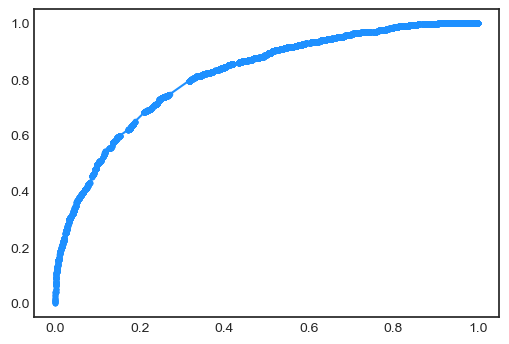

In [12]:
print('AUROC:',np.round(roc_auc_score(y, pred_values), 3))
lr_fpr, lr_tpr, _ = roc_curve(y, pred_values)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic', color='dodgerblue');

In [13]:
auroc = roc_auc_score(y, pred_values)
gini = 2 * auroc - 1
print('Gini:',np.round(gini, 3))

Gini: 0.629


# 6. Confusion Matrix
* A confusion matrix is a performance evaluation tool in machine learning, representing the accuracy of a classification model. 
* It displays the number of true positives, true negatives, false positives, and false negatives.

In [14]:
train_dict = {'actuals':y, 'predicted':pred_values}
test_calc = pd.DataFrame(train_dict)

max f:  0.2
max a:  0.5


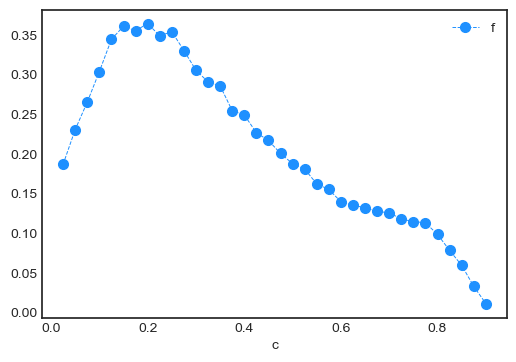

In [15]:
c = []
f = []
a = []

for j in range(25,1000,25):
    i = j/1000
    test_calc['flag'] = np.where(test_calc['predicted']>i, 1, 0)
    df_table = confusion_matrix(test_calc['actuals'],test_calc['flag'])
    p = df_table[1,1] / (df_table[1,1] + df_table[0,1])
    r = df_table[1,1] / (df_table[1,1] + df_table[1,0])
    
    c.append(i)
    f.append((2 * p * r) / (p + r))
    a.append((df_table[0,0] + df_table[1,1]) / df_table.sum())

df_decision = pd.concat([pd.DataFrame(c),pd.DataFrame(f),pd.DataFrame(a)],axis=1)
df_decision.columns = ['c','f','a']
f_max = df_decision[df_decision['f']==df_decision['f'].max()].head(1)
a_max = df_decision[df_decision['a']==df_decision['a'].max()].head(1)
max_f = float(f_max['c'])
max_a = float(a_max['c'])

df_decision.plot(x='c', y='f', marker="o", ms=7, color='dodgerblue', ls='--', lw=0.7)
print ("max f: ",max_f)
print ("max a: ",max_a)

# 7. Accuracy and F1 Score
* The overall accuracy is calculated by summing the number of correctly classified values and dividing by the total number of values.
* The F1 score is a measure of a model's accuracy that takes both precision and recall into account. It is the harmonic mean of precision and recall.

In [21]:
def cut_off (x):
    if x > 0.2: return 1
    else: return 0
test_calc['flag'] = test_calc['predicted'].apply(cut_off)
print(confusion_matrix(test_calc['actuals'],test_calc['flag']))

[[88789  4872]
 [ 4781  2765]]


In [22]:
c = confusion_matrix(test_calc['actuals'],test_calc['flag'])
print('Accuracy:',np.round((c[0][0] + c[1][1]) / c.sum(),3))

Accuracy: 0.905


In [23]:
p = c[1][1] / (c[1][1] + c[0][1])
r = c[1][1] / (c[1][1] + c[1][0])
print('F1 Score:',np.round((2 * p * r) / (p + r),3))

F1 Score: 0.364


# 8. KS
* Kolmogorov-Smirnov statistics captures the discriminatory power of the model in separating “Good” from “Bad”. 
* It is the highest separation between the Cumulative Good Rate and Cumulative Bad Rate. 
* Higher the KS, better is the model (higher separation between good and bad).

In [24]:
test_calc['1-predicted'] = 1-test_calc['predicted']
test_calc['bucket'] = pd.qcut(test_calc['1-predicted'], 10, labels=['b1','b2','b3','b4','b5','b6','b7','b8','b9','b10'])
kstable = test_calc.groupby('bucket', as_index = False)[['1-predicted','predicted']].sum()
kstable['event_rate'] = (kstable['predicted'] / kstable['predicted'].sum()).cumsum()
kstable['non_event_rate'] = (kstable['1-predicted'] / kstable['1-predicted'].sum()).cumsum()
kstable['KS'] = (kstable['event_rate'] - kstable['non_event_rate']).abs()
print(np.round(kstable['KS'].max(), 3))

0.429


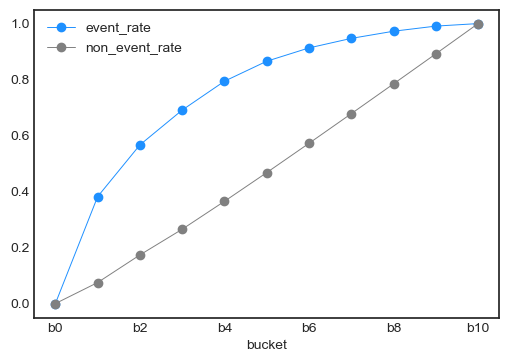

In [25]:
ks_bin0 = pd.DataFrame({'bucket':'b0','event_rate':0,'non_event_rate':0}, index=[10])
kstable = pd.concat([ks_bin0, kstable])
kstable.plot(x='bucket', y=['event_rate','non_event_rate'], marker="o", color=['dodgerblue','gray'], lw=0.7);